### TASK 8- Pipeline

In [43]:
# import things
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Conv2DTranspose, 
    Dropout, concatenate
)
from tensorflow.keras.models import Model
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects
from patchify import patchify, unpatchify
from tensorflow.keras.models import load_model
from pathlib import Path
from keras.utils import get_custom_objects
from PIL import Image
import cv2
from skimage.measure import label, regionprops
from scipy.spatial.distance import euclidean
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
import csv
import heapq
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra

### Loading the model and the dataset

In [44]:
def load_unet_model(patch_size, model_path):
    # Load the model 
    model = load_model(model_path)
    return model

In [45]:
def load_image(image_path):
    """
    Load an image from the path and return the image and its shape.
    """
    try:
        image = Image.open(image_path)
        image = np.array(image)  # Convert to numpy array if needed for further processing
        return image, image.shape
    except Exception as e:
        print(f"Error loading image at {image_path}: {e}")
        raise

### Preprocess functions from Task 2

In [46]:
def preprocess_image(image):
    """
    Preprocess the image by converting it to grayscale.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

In [47]:
def process_and_crop_image(image, padding=10):
    """
    Process the image by applying blur, edge detection, cropping, and padding.
    """
    
    gray_image = image  
    
    # Apply Gaussian Blur
    im_blurred = cv2.GaussianBlur(gray_image, (13, 13), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(im_blurred, threshold1=30, threshold2=30)

    # Dilate edges to ensure contours near image border are captured
    edges = cv2.dilate(edges, None, iterations=2)

    # Find contours in the edges image
    contours_image, _ = cv2.findContours(edges, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours
    contours_image = [cnt for cnt in contours_image if cv2.contourArea(cnt) > 100]

    if contours_image:
        # Get the bounding box of the largest contour (by area)
        outermost_contour = max(contours_image, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3])
        x, y, w, h = cv2.boundingRect(outermost_contour)

        # Apply padding to the bounding box
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(gray_image.shape[1] - x, w + 2 * padding)
        h = min(gray_image.shape[0] - y, h + 2 * padding)

        # Crop the image using the bounding box
        cropped_image = gray_image[y:y+h, x:x+w]  # Use grayscale for cropping

        # Ensure the cropped image is square by centering it on a square canvas
        max_size = max(w, h)
        square_image = np.zeros((max_size, max_size), dtype=np.uint8)  # Grayscale canvas

        x_offset = (max_size - w) // 2
        y_offset = (max_size - h) // 2
        square_image[y_offset:y_offset+h, x_offset:x_offset+w] = cropped_image

        return square_image

    print("No contours found.")
    return None

### Task 3 

In [48]:
def plant_segmentation_pipeline(image):
    # Ensure the image is in the correct format (uint8)
    if image.dtype != np.uint8:
        image = np.array(image, dtype=np.uint8)
    
    # Step 1: Apply Gaussian blur to smooth the image and reduce edge noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Step 2: Apply OTSU thresholding for background removal
    th, output_im = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Step 3: Morphological operations to remove edge noise
    kernel = np.ones((5, 5), np.uint8)  # Larger kernel for dilation and erosion
    dilated_image = cv2.dilate(output_im, kernel, iterations=1)  # Dilation to expand regions
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)  # Erosion to shrink regions back
    
    # Step 4: Find connected components (to identify regions in the image)
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded_image)
    
    # Step 5: Create an output mask with up to 5 largest components (plants)
    output = np.zeros_like(labels, dtype=np.uint8)
    for i in range(1, retval):  # Starting from 1 to skip background component
        x, y, w, h, area = stats[i]
        if area > 300:  # Optional: Only keep large components 
            output[labels == i] = 255  # Mark the detected root as white (255)
    
    # Step 6: Crop away components near the edges to remove unwanted noise
    h, w = output.shape
    edge_size = 150  # Crop the first and last 50 pixels
    output[:edge_size, :] = 0  # Remove the top
    output[-edge_size:, :] = 0  # Remove the bottom
    output[:, :edge_size] = 0  # Remove the left
    output[:, -edge_size:] = 0  # Remove the right

    return output

### Inference from Task 5

In [49]:
def f1(y_true, y_pred):
    """
    Calculate the F1 score based on precision and recall.
    """
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [50]:
def padder(image, patch_size):
    """
    Adds padding to an image to ensure its dimensions are a multiple of patch_size
    while preserving quality.
    """
    h, w = image.shape[:2]

    # Calculate the necessary padding
    height_padding = ((h + patch_size - 1) // patch_size) * patch_size - h
    width_padding = ((w + patch_size - 1) // patch_size) * patch_size - w

    # Distribute padding evenly
    top_padding = height_padding // 2
    bottom_padding = height_padding - top_padding
    left_padding = width_padding // 2
    right_padding = width_padding - left_padding

    # Apply padding using reflection to maintain edge continuity
    padded_image = cv2.copyMakeBorder(
        image, top_padding, bottom_padding, left_padding, right_padding,
        cv2.BORDER_REFLECT
    )

    return padded_image

In [51]:
def predict_mask_from_patches(petri_dish_padded, patch_size, model):
    """
    Process an image by dividing it into patches, passing the patches through a model,
    and reconstructing the predicted mask for the entire image.

    """
    # Step 1: Extract patches from the input image
    patches = patchify(petri_dish_padded, (patch_size, patch_size), step=patch_size)

    # Step 2: Reshape patches to match the model input (assuming grayscale channels, change 1 if using RGB)
    i, j = patches.shape[0], patches.shape[1]
    patches = patches.reshape(-1, patch_size, patch_size, 1)  # Adjust channels as needed (1 for grayscale, 3 for RGB)

    # Step 3: Get predictions from the model
    preds = model.predict(patches)

    # Step 4: Reshape predictions back to the grid shape
    preds = preds.reshape(i, j, patch_size, patch_size)

    # Step 5: Reconstruct the predicted mask from the patches
    predicted_mask = unpatchify(preds, (petri_dish_padded.shape[0], petri_dish_padded.shape[1]))

    return predicted_mask

### Task 6 

In [52]:
def preprocess_root_mask(mask):
    """
    Preprocesses the root mask by applying morphological closing and dilation for better segmentation.
    """
    binary_roots = mask * 255  # Convert to binary format (0-255)
    kernel = np.ones((5,5), np.uint8)  # Structuring element for closing
    closed_image = cv2.morphologyEx(binary_roots, cv2.MORPH_CLOSE, kernel)  # Morphological close
    kernel = np.ones((3,3), np.uint8)  # Smaller kernel for dilation
    root_skeleton = cv2.dilate(closed_image, kernel, iterations=1)  # Dilate to refine structure
    return root_skeleton

In [53]:
def segment_individual_roots(mask):
    """
    Segments individual roots from the given binary root mask and assigns them to one of 5 vertical regions.
    """
    # Segment the mask (assumed to be preprocessed)
    binary_mask = (mask > 0.5).astype(np.uint8) * 255  # Convert to binary format (0-255)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask)
    
    height, width = mask.shape
    region_width = width // 5  # Split into 5 vertical regions
    
    # Store root masks per region
    region_roots = {i: [] for i in range(5)}  # Dictionary to hold roots for each region
    size_threshold = 300  # Minimum size to filter noise
    
    for i in range(1, num_labels):  # Skip background
        x, y, w, h, area = stats[i]
        if area > size_threshold:
            region_index = min(x // region_width, 4)  # Assign root to one of 5 regions
            region_roots[region_index].append((area, (labels == i).astype(np.uint8) * 255))
    
    # Select at most one largest root per region
    final_roots = []
    for region in range(5):
        if region_roots[region]:
            # Choose the largest root by area
            largest_root = max(region_roots[region], key=lambda x: x[0])[1]
            final_roots.append((largest_root, region))
        else:
            final_roots.append((None, region))  # No plant in this region
    
    return final_roots

In [54]:
def display_root_masks_with_boxes(mask, filtered_components, stats, labels):
    """Displays the segmented root masks with bounding boxes."""
    if len(filtered_components) == 0:
        print("No roots detected in this image.")
        return  # Exit the function early if no roots are found

    fig, axes = plt.subplots(1, len(filtered_components), figsize=(30, 10))
    if len(filtered_components) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one component
    
    for idx, comp_id in enumerate(filtered_components):
        root_mask = np.where(labels == comp_id, 255, 0).astype(np.uint8)
        
        # Draw bounding box for each component (root)
        x, y, w, h, area = stats[comp_id]
        cv2.rectangle(root_mask, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        # Plot the root mask with bounding box
        axes[idx].imshow(root_mask, cmap='gray')
        axes[idx].set_title(f"Root {comp_id} - Area: {area}")
        axes[idx].axis('off')

    plt.show()

### Task 7

In [55]:
def calculate_root_length(skeleton_image):
    """
    Calculates the length of the root based on the number of non-zero pixels in the skeletonized image.
    """
    # Count the number of non-zero pixels in the skeleton image (each pixel corresponds to part of the root)
    root_length = np.sum(skeleton_image > 0)  # Non-zero pixels in the skeleton image
    return root_length

In [56]:
def process_individual_roots_with_lengths(segmented_roots):
    """
    Processes each individual root mask, calculates its length, and visualizes it.
    """
    for idx, (root_mask, root_stats) in enumerate(segmented_roots):
        # Skeletonize the root mask
        skeleton_image = skeletonize(root_mask > 0)  # Skeletonize only the non-zero part (root area)
        
        # Calculate root length (in pixels)
        root_length = calculate_root_length(skeleton_image)
        
        # Visualize the skeletonized root and display length
        plt.imshow(skeleton_image, cmap='gray')
        plt.title(f"Skeletal Root {idx + 1} (Length: {root_length} pixels)")
        plt.axis('off')
        plt.show()

        # Optionally: Store root length in a dictionary or list if you want to use it later
        print(f"Root {idx + 1} length: {root_length} pixels")

### Visualization

In [57]:
def overlay_predictions_on_image(original_image, restored_mask):
    """
    Apply a red overlay on the original grayscale image where the predicted mask is present.
    """
    # Convert the grayscale image to RGB so we can add color
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)

    # Create an empty image to hold the red-colored mask
    red_mask = np.zeros_like(rgb_image)

    # Assign red color where the mask is active
    red_mask[:, :, 0] = restored_mask * 255  # Red channel

    # Blend the original image with the red mask overlay
    result = cv2.add(rgb_image, red_mask)

    return result

### Extra functions

In [58]:
def longest_root_path(region, highest_point, lowest_point):
    """
    A simplified version of the Dijkstra-like algorithm for finding the longest root path
    without using NetworkX.
    """
    # Create a mask for the region where we will find the path
    visited = np.zeros_like(region, dtype=bool)
    queue = [(highest_point[0], highest_point[1], 0)]  # (y, x, distance)
    
    # Directions for 4 neighbors (up, down, left, right)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    longest_path = 0

    while queue:
        y, x, dist = queue.pop(0)
        
        # Skip if the point is out of bounds or already visited
        if not (0 <= y < region.shape[0] and 0 <= x < region.shape[1]) or visited[y, x]:
            continue
        
        visited[y, x] = True
   
        # If we reach the lowest point, update the longest path
        if (y, x) == tuple(lowest_point):
            longest_path = max(longest_path, dist)
            continue
        
        # Explore the 4 neighbors
        for dy, dx in directions:
            ny, nx = y + dy, x + dx
            if 0 <= ny < region.shape[0] and 0 <= nx < region.shape[1] and region[ny, nx] > 0:
                queue.append((ny, nx, dist + 1))

    # Return the longest path found (if any)
    return longest_path if longest_path > 0 else np.linalg.norm(np.array(highest_point) - np.array(lowest_point))


def process_and_connect_in_regions(image, num_regions=5):
    """
    Process the image by splitting it into vertical regions, identifying the highest and lowest points 
    in each region, drawing a connecting line, and measuring the root length.
    This function will return the root lengths for each region.
    """
    # Get image dimensions
    height, width = image.shape

    # Calculate width of each region
    region_width = width // num_regions

    # Store root lengths
    root_lengths = []

    for i in range(num_regions):
        # Define the start and end x-coordinates for the region
        start_x = i * region_width
        end_x = (i + 1) * region_width if i != num_regions - 1 else width  # Ensure last region goes to end of image

        # Extract the region from the image
        region = image[:, start_x:end_x]

        # Find the highest and lowest non-zero pixels (white pixels)
        nonzero_pixels = np.column_stack(np.where(region > 0))  # Get (y, x) coordinates of white pixels

        if len(nonzero_pixels) > 0:
            highest_point = nonzero_pixels[np.argmin(nonzero_pixels[:, 0])]  # Smallest y value (topmost)
            lowest_point = nonzero_pixels[np.argmax(nonzero_pixels[:, 0])]   # Largest y value (bottommost)

            # Compute the longest root path using the custom BFS-like approach
            root_length = longest_root_path(region, highest_point, lowest_point)
            root_lengths.append(root_length)
        else:
            # No plant in this region, set root length to 0
            root_lengths.append(0)

    return root_lengths

### Saving 

In [59]:
def save_overlayed_image(image, predicted_mask, image_file, output_folder):
    """Overlays predictions on image and saves it."""
    overlay_image = overlay_predictions_on_image(image, predicted_mask)
    overlay_image_path = os.path.join(output_folder, f"overlayed_{image_file}")
    cv2.imwrite(overlay_image_path, overlay_image)
    print(f"Saved overlayed image: {overlay_image_path}")

In [60]:
def save_root_lengths_to_csv(root_lengths, output_folder):
    """Saves root lengths to a CSV file."""
    csv_filename = os.path.join(output_folder, "root_lengths.csv")
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Plant ID", "Length (px)"])
        writer.writerows(root_lengths)
    print(f"Saved root lengths to {csv_filename}")

### Main function

In [61]:
def process_images_in_folder(folder_path, model, output_folder, patch_size):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialize a list to store root lengths and corresponding Plant IDs
    root_lengths = []

    # Get all image files in the folder and sort them in chronological order
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
    image_files.sort(key=lambda x: int(x.split('_')[2].split('.')[0]))  # Sort by the number in the filename

    # Iterate through all images in the folder in sorted order
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image, image_shape = load_image(image_path)
        print(f"Loaded image: {image_file} with shape: {image_shape}")
        
        gray_image = preprocess_image(image)
        processed_image = process_and_crop_image(gray_image)

        if processed_image is not None:
            # Pad the image for patch processing
            padded_image = padder(processed_image, patch_size)
            print(f"Padded image shape: {padded_image.shape}")

            # Get the predicted mask
            predicted_mask = predict_mask_from_patches(padded_image, patch_size, model)
            print(f"Predicted mask shape: {predicted_mask.shape}")

            # Segment the plants from the predicted mask
            segmented_plants_mask = plant_segmentation_pipeline(predicted_mask)

            # Display the segmented result
            plt.imshow(segmented_plants_mask, cmap='gray')
            plt.title(f"Segmented Plants {image_file}")
            plt.show()

            # Convert to binary (0 and 1) and ensure uint8 format
            binary_mask = (segmented_plants_mask > 0.5).astype(np.uint8)

            # Preprocess the root mask (using the function from Option 2)
            processed_root_mask = preprocess_root_mask(segmented_plants_mask)

            # Run connectedComponentsWithStats to find individual roots
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(processed_root_mask)

            # Call process_and_connect_in_regions function to calculate root lengths for each region
            root_lengths_for_image = process_and_connect_in_regions(segmented_plants_mask)
            print(f"Root lengths for {image_file}: {root_lengths_for_image}")

            # Append the root lengths for the current image to the main list
            plant_id = 1
            for length in root_lengths_for_image:
                # Assign plant ID and store the result
                plant_id_str = f"{image_file.split('.')[0]}_plant_{plant_id}"
                root_lengths.append([plant_id_str, length])
                plant_id += 1

            # Overlay the predicted mask on the original image and save it
            overlay_image = overlay_predictions_on_image(padded_image, predicted_mask)
            overlay_image_path = os.path.join(output_folder, f"overlayed_{image_file}")
            cv2.imwrite(overlay_image_path, overlay_image)
            print(f"Saved overlayed image: {overlay_image_path}")
        else:
            print(f"Skipped {image_file}: No valid processed image.")

    # Save the root lengths to a CSV file
    csv_filename = os.path.join(output_folder, "root_lengths.csv")
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Plant ID", "Length (px)"])  # Write header
        writer.writerows(root_lengths)
    
    print(f"Saved root lengths to {csv_filename}")

In [62]:
# Register f1 before loading the model
get_custom_objects().update({'f1': f1})

Loaded image: test_image_1.tif with shape: (3006, 4202, 3)
Padded image shape: (3072, 3072)
5/5 [==============================] - 6s 1s/step
Predicted mask shape: (3072, 3072)


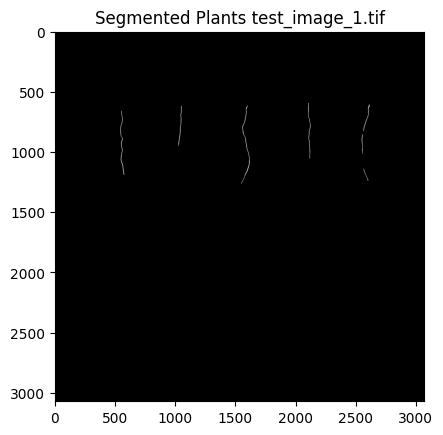

Root lengths for test_image_1.tif: [607, 360, 652.4944444207936, 498, 635.0787352761861]
Saved overlayed image: Output/overlayed_test_image_1.tif
Loaded image: test_image_2.tif with shape: (3006, 4202, 3)
Padded image shape: (3072, 3072)
5/5 [==============================] - 6s 1s/step
Predicted mask shape: (3072, 3072)


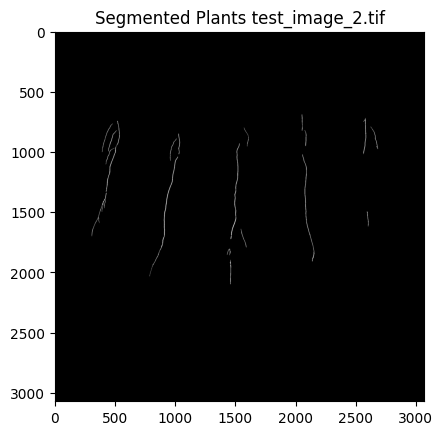

Root lengths for test_image_2.tif: [978.7931344262688, 1209.2584504563117, 1304.730240317898, 1222.957480863501, 900.2938409208407]
Saved overlayed image: Output/overlayed_test_image_2.tif
Loaded image: test_image_3.tif with shape: (3006, 4202, 3)
Padded image shape: (3072, 3072)
5/5 [==============================] - 6s 1s/step
Predicted mask shape: (3072, 3072)


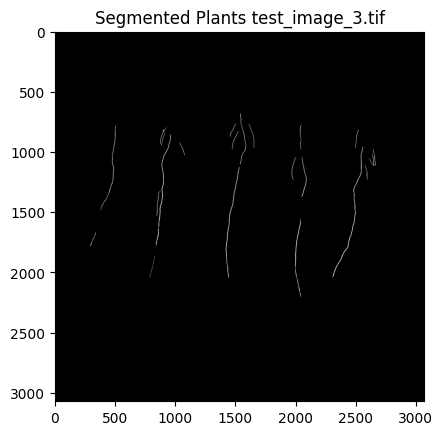

Root lengths for test_image_3.tif: [1023.9750973534464, 1252.5150697696215, 1367.5880227612408, 1429.0055983095378, 882.1813872441427]
Saved overlayed image: Output/overlayed_test_image_3.tif
Loaded image: test_image_4.tif with shape: (3006, 4202, 3)
Padded image shape: (3072, 3072)
5/5 [==============================] - 6s 1s/step
Predicted mask shape: (3072, 3072)


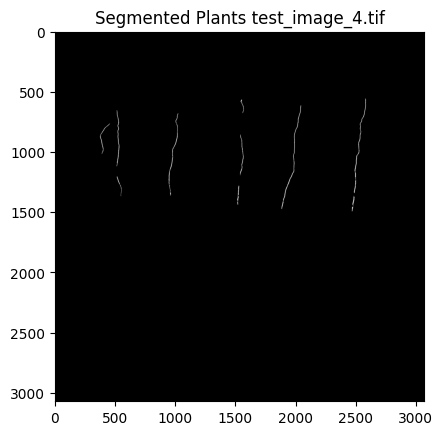

Root lengths for test_image_4.tif: [714.7621982170014, 684.0007309937614, 874.5495983647811, 1024, 942.6770390754195]
Saved overlayed image: Output/overlayed_test_image_4.tif
Loaded image: test_image_5.tif with shape: (2999, 4202, 3)
Padded image shape: (4352, 4352)
10/10 [==============================] - 12s 1s/step
Predicted mask shape: (4352, 4352)


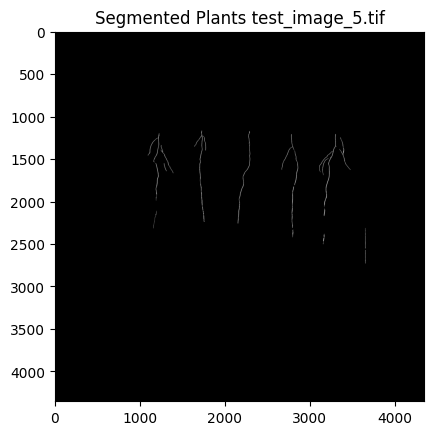

Root lengths for test_image_5.tif: [0, 1283.9633951168546, 1275, 1305.0800741716962, 418.0011961705373]
Saved overlayed image: Output/overlayed_test_image_5.tif
Loaded image: test_image_6.tif with shape: (3006, 4202, 3)
Padded image shape: (3072, 3072)
5/5 [==============================] - 6s 1s/step
Predicted mask shape: (3072, 3072)


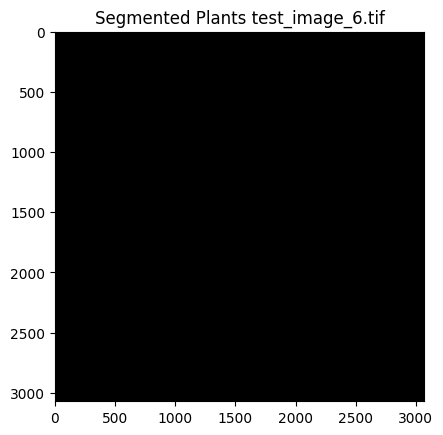

Root lengths for test_image_6.tif: [0, 0, 0, 0, 0]
Saved overlayed image: Output/overlayed_test_image_6.tif
Loaded image: test_image_7.tif with shape: (3006, 4202, 3)
Padded image shape: (3072, 3072)
5/5 [==============================] - 6s 1s/step
Predicted mask shape: (3072, 3072)


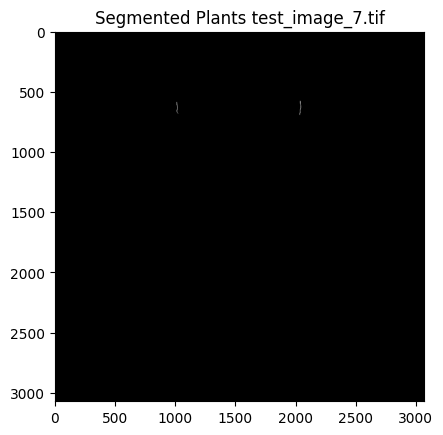

Root lengths for test_image_7.tif: [0, 112, 0, 129, 0]
Saved overlayed image: Output/overlayed_test_image_7.tif
Loaded image: test_image_8.tif with shape: (3006, 4202, 3)
Padded image shape: (3072, 3072)
5/5 [==============================] - 6s 1s/step
Predicted mask shape: (3072, 3072)


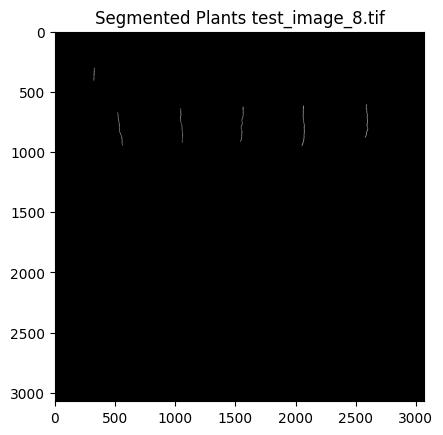

Root lengths for test_image_8.tif: [685.1948627945192, 286.2516375499012, 325, 365, 315]
Saved overlayed image: Output/overlayed_test_image_8.tif
Loaded image: test_image_9.tif with shape: (3006, 4202, 3)
Padded image shape: (3072, 3072)
5/5 [==============================] - 6s 1s/step
Predicted mask shape: (3072, 3072)


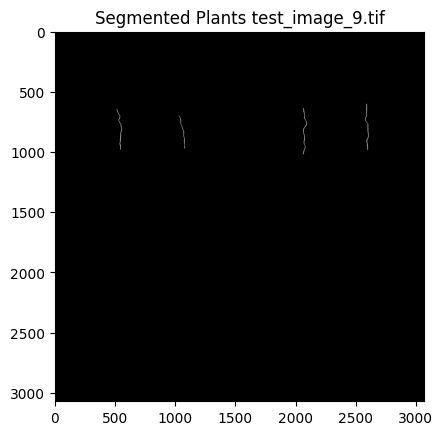

Root lengths for test_image_9.tif: [404, 325, 0, 470, 384.15751977541714]
Saved overlayed image: Output/overlayed_test_image_9.tif
Loaded image: test_image_10.tif with shape: (3006, 4202, 3)
Padded image shape: (3072, 3072)
5/5 [==============================] - 6s 1s/step
Predicted mask shape: (3072, 3072)


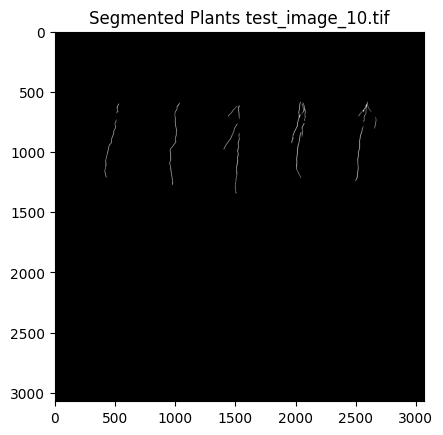

Root lengths for test_image_10.tif: [624.3877000710376, 809, 731.5360551606462, 634.0031545662845, 665.5554071600651]
Saved overlayed image: Output/overlayed_test_image_10.tif
Loaded image: test_image_11.tif with shape: (3006, 4202, 3)
Padded image shape: (3072, 3072)
5/5 [==============================] - 6s 1s/step
Predicted mask shape: (3072, 3072)


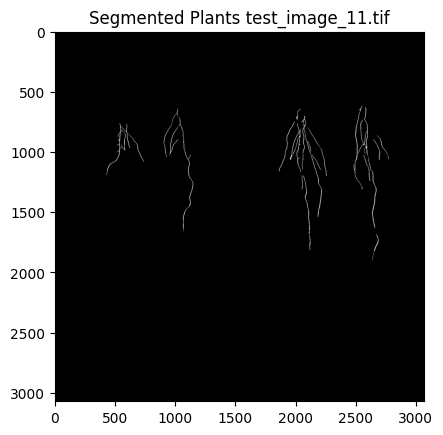

Root lengths for test_image_11.tif: [560, 1018.0397831126247, 0, 1176.655004663644, 1285.9463441372661]
Saved overlayed image: Output/overlayed_test_image_11.tif
Saved root lengths to Output/root_lengths.csv


In [63]:
folder_path = "Input"
output_folder = "Output"
patch_size = 256
model =  load_model(r"/home/y2b/nicola_230632_unet_model_256px.h5")
step = 128 
batch_size = 64
process_images_in_folder(folder_path, model, output_folder, patch_size)